### Imported Libraries for CNN Project to Classify Alzhiemers

In [136]:
# Include needed import modules
import os
import pandas as pd
import regex as re
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [137]:
from mpl_toolkits import mplot3d
from matplotlib import pyplot as plt

### Class for loading ADNI data as Nifti file and loading ResNet-50

In [142]:
# Create class for loading NiftiDataset

pattern = r"I[0-9]+"
class NiftiDataset(Dataset):
    def __init__(self, image_dir, csv_file, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.csv_data = pd.read_csv(csv_file).to_dict(orient='records')
        self.images = self.get_all_nifti_files(image_dir)

    def get_all_nifti_files(self, folder_path):
        # Recusrievly find files in folder_path that match regex
        nii_files = []
        for subdir, _, files in os.walk(folder_path):
            for file in files:
                if file.endswith(".nii"):
                    nii_files.append(os.path.join(subdir, file))
        print(f"Loaded {len(nii_files)} .nii files from {folder_path}\n")
        return nii_files

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        nii_data = nib.load(self.images[idx])
        img = nii_data.get_fdata()
        # img = nib.load(self.images[idx]).get_fdata()  # Load NIfTI image as NumPy array
        img = np.array(img, dtype=np.float32)
        
        # Assume middle slice
        middle_index = img.shape[2] // 2
        img = img[:, :, middle_index] #(Shape is 244, 244)

        # Normalize the image intensity
        img = (img - np.min(img)) / (np.max(img) - np.min(img)) * 255 # Min-max normalization
        img = img.astype(np.uint8)

        img = Image.fromarray(img) # Convert to PIL image
        
        if self.transform:
            img = self.transform(img)

        label = self.get_label_from_filename(self.images[idx])  # Implement a function to map filenames to labels
        return img, label

    def get_label_from_filename(self, filename):
        """Extract label based on filename convention."""
        id = re.search(pattern, filename).group()
        for row in self.csv_data:
            if row['Image Data ID'] == id:
                if "CN" in row['Group']:
                    return 0 # Congitively Normal
                if "MCI" in row['Group']:
                    return 1 # Mild Cognitive Impairment
                elif "AD" in row['Group']:
                    return 2 # Alzheimer's Disease
                return -1

In [143]:
# Create class for loading ResNet-40 model
class AlzheimerResNet(nn.Module):
    def __init__(self, num_classes=3):
        super(AlzheimerResNet, self).__init__()
        self.model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes) # Modify the output layer
    
    def forward(self, x):
        return self.model(x)

### Loading ADNI dataset

In [144]:
# Create transformations and loading dataset

transform = transforms.Compose([
    transforms.Resize((224, 244)), # Resize to fit ResNet-50
    transforms.Grayscale(num_output_channels=3), # Convert to 3 channels
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet Normalization
    # transforms.Normalize(mean=[0.5], std=[0.5]) # Normalizing single-channel data
])


full_dataset = NiftiDataset(image_dir=".\\adni_dataset\\ADNI", csv_file=".\\adni_dataset\\ADNI1_Complete_1Yr_1.5T_3_05_2025.csv", transform=transform)

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

Loaded 38 .nii files from .\adni_dataset\ADNI



2


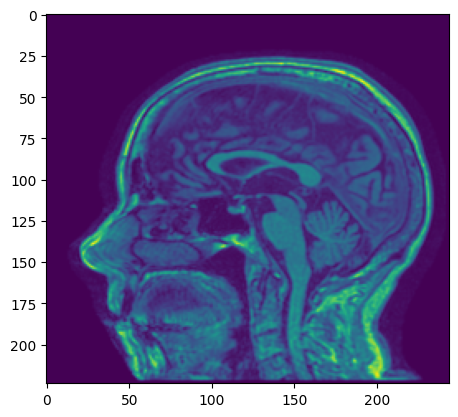

In [145]:
## Sample some of the images
adni_sample, label = train_dataset[1]
print(label) # 0 = CN, 1 = MCI, 2 = AD (Current sample is AD)
plt.imshow(adni_sample[2,:,:]) # Image contained is a 3 rgb with 224 x 224 size.

### Loading Pretrained Resnet-50

In [146]:
# Retrieve Resnet-50 model
model = AlzheimerResNet().to(device)

# Defline loss function
criteria = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

### Evaluation Function

In [147]:
#Define loss function
loss_function = nn.CrossEntropyLoss()

In [148]:
def evalulate_model(model, val_loader):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = loss_function(outputs, labels)

            total_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    avg_loss = total_loss / total
    accuracy = correct / total
    return accuracy, avg_loss 

### Train Function

In [149]:
def train_model(model, criteria, optimizer, train_loader, val_loader, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criteria(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = correct / total
        val_acc, val_loss = evalulate_model(model, val_loader)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, Train Acc: {train_acc:.2f}, Val Acc: {val_acc:.2f}, Val Loss: {val_loss:.2f}")

In [150]:
train_model(model, criteria, optimizer, train_loader, val_loader, num_epochs=10)

Epoch [1/10], Loss: 1.0734, Train Acc: 0.40, Val Acc: 0.25, Val Loss: 1.10
Epoch [2/10], Loss: 0.8682, Train Acc: 0.97, Val Acc: 0.25, Val Loss: 1.08
Epoch [3/10], Loss: 0.6228, Train Acc: 1.00, Val Acc: 0.38, Val Loss: 1.06
Epoch [4/10], Loss: 0.4321, Train Acc: 1.00, Val Acc: 0.62, Val Loss: 1.05
Epoch [5/10], Loss: 0.3022, Train Acc: 1.00, Val Acc: 0.75, Val Loss: 1.05
Epoch [6/10], Loss: 0.2035, Train Acc: 1.00, Val Acc: 0.62, Val Loss: 1.05
Epoch [7/10], Loss: 0.1441, Train Acc: 1.00, Val Acc: 0.62, Val Loss: 1.05
Epoch [8/10], Loss: 0.0888, Train Acc: 1.00, Val Acc: 0.62, Val Loss: 1.04
Epoch [9/10], Loss: 0.0830, Train Acc: 1.00, Val Acc: 0.62, Val Loss: 1.02
Epoch [10/10], Loss: 0.0371, Train Acc: 1.00, Val Acc: 0.62, Val Loss: 1.01


In [151]:
torch.save(model.state_dict(), "alzheimer_resnet50.pth")